In [1]:
import matplotlib.pyplot as plt

## Introducción

Hay un potencial de ahorro económico en la calefacción de espacios, siempre que se cumplan las premisas de que la calefacción sea eléctrica y la tarifa eléctrica tenga discriminación horaria. El método a emplear sería el encendido del sistema en las horas de menor coste y el aprovechamiento de la inercia térmica de la estancia para mantenerse dentro de la temperatura de confort.

Teniendo en cuenta que, con esta estrategia, el consumo eléctrico aumenta, el ahorro viene dado por la diferencia de precio de la electricidad entre las distintas horas, y ésta no siempre será suficiente para compensar la mayor cantidad de energía empleada.

Dado que tanto el precio de la electricidad como la temperatura exterior prevista se conocen con una antelación suficiente, es posible hacer la predicción de gasto en calefacción para cada día con estrategias distintas, y obtener la más barata.

Este proyecto trata de generar el modelo para realizar esta predicción para una vivienda en concreto, en base a datos reales recogidos en la misma entre noviembre de 2022 y marzo de 2023. El sistema de calefacción es en base a bomba de calor, y la tarifa eléctrica es la PVPC, con discriminación horaria.

## Dataset

Los datos se extraen de una base de datos InfluxDB, mediante las consultas pertinentes, y se vuelcan a un archivo de tipo csv.  
La información se obtiene en forma de serie temporal, con un registro cada hora, superando los 3600 registros.  
Las columnas corresponden a timestamp, temperatura interior, exterior, precio de la electricidad y consumo eléctrico aumulado,  
valores medios para cada hora. 
El análisis en profundidad de los datos se puede encontrar en mi EDA.

## Preprocesamiento de los datos

Encontramos valores nulos en todas las columnas excepto timestamp, en su mayor parte consecuencia de la forma en que InfluxDB almacena y devuelve estos valores, y podemos completarlos en base a suposiciones razonables que se explicaron en mi EDA.  
Para la columna €/kWh completamos con los valores anteriores, igual que en la temperatura interior y el consumo eléctrico.
Para la temperatura exterior interpolamos entre los valores existentes.  

A continuación generamos nuevas columnas a partir de las existentes:  
* Generamos la columna consumo como diferencia entre valores sucesivos de kWh, que es acumulativa, para obtener el consumo eléctrico cada hora.  
* Creamos la columna €/h como producto de la anterior por el precio horario de la electricidad, para obtener los € consumidos en cada hora.  
* Añadimos los valores de las 24 horas previas para temperatura interior, exterior y precio de electricidad, en forma de nuevas columnas.  
* Por último, añadimos la columna €/dia, con la suma de los € consumidos cada hora en las 24 horas anteriores, que será el valor que queremos predecir.

## Modelado

El problema al que nos enfrentamos es de regresión: a partir de una serie de variables numéricas (temperatura interior, exterior, precio de la electricidad y consumo eléctrico) queremos predecir el coste en € de calentar la estancia durante un día.  

Para ello vamos a probar los siguientes modelos: Random Forest Regressor, Linear Regression, Ridge, Lasso y XGBoost Regressor.  
Instanciamos un pipeline con todos ellos e incluímos un Grid Search Cross Validation para probar distintos hiperparámetros en cada uno, empleando la métrica de Mean Absolute Error como medida de su eficacia.

El modelo que emerge como más adecuado es un XGBoost Regressor, con un learning rate de 0.2, max depth de 3 y n_estimators de 50.  

Mediante un pickle guardamos el modelo ya entrenado en forma de binario para su uso posterior.


## Predicción y resultados finales

El resultado es un modelo que predice el gasto en calefacción para cada día, a partir de los datos de temperatura exterior y precio de electricidad, disponibles desde el día anterior, así como la temperatura interior, que nosotros fijaremos.
Solicitando predicciones con distintos horarios y temperaturas, podemos ver cuál será el coste en cada caso, y escoger la alternativa más barata.

En la gráfica a continuación podemos ver la representación de los valores reales y predichos para todo el período en estudio

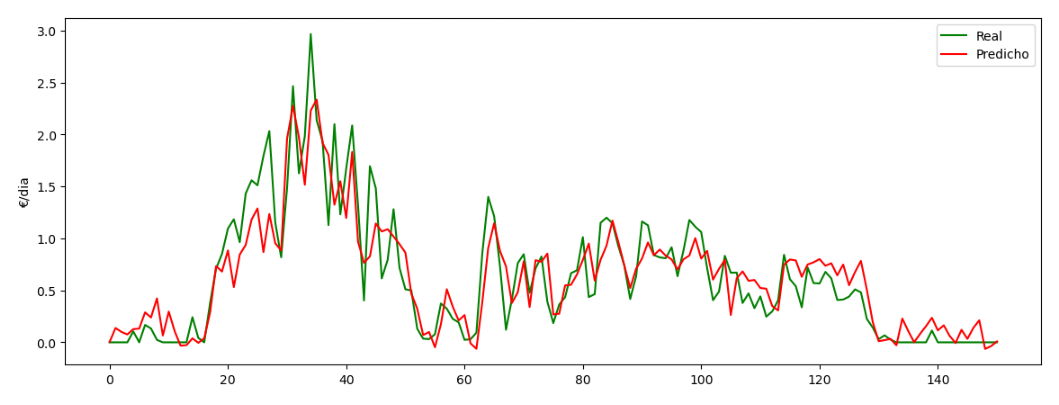

In [2]:
img = plt.imread('./img/real_vs_predicho.png')
plt.figure(figsize= (14, 5))
plt.imshow(img)
plt.axis('off');

## Conclusiones y futuros pasos

El resultado es un sistema para predecir el gasto en calefacción en base a datos que están públicamente disponibles, y que se pueden consultar mediante APIs, permitiendo al usuario calentar su espacio de una forma potencialmente más económica.

Entre las debilidades del proyecto están que es específico para una estancia concreta y que requiere de un historial de datos recogidos para entrenar el modelo en cada nueva instancia.


La idea de futuro incluye los siguientes apartados:  
* Obtener la temperatura exterior prevista para las 24 horas del día siguiente usando la API de AEMET  
* Obtener el precio de la electricidad para las 24 horas del día siguiente usando la API de ESIOS  
* Obtener la temperatura deseada para las 24 horas del día siguiente a partir de la programación del termostato en la plataforma de domótica Home Assistant  
* Utilizar un algoritmo genético para determinar la estrategia más económica, y activar la calefacción de acuerdo a la misma, empleando también Home Assistant
